# Long Short-Term Memory
### Project 2 - Data Science
- Abner Gardia 21285
- Esteban Donis 21610
- Daniel Gomez 21429

In [14]:
# Bloque 1: Importar librerías y cargar dataset
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

Con la data limpia, procedemos a preparar los modelos de LSTM

In [15]:
discourses = pd.read_csv('./result/data_cleaned.csv')
discourses.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text_length,word_count
0,0013cc385424,007ACE74B050,hi isaac going writing face mars natural landf...,4,0,164,27
1,9704a709b505,007ACE74B050,perspective think face natural landform nott t...,5,0,107,15
2,c22adee811b6,007ACE74B050,think face natural landform life mars descover...,0,0,52,8
3,a10d361e54e4,007ACE74B050,life mars would know reason think natural land...,3,0,199,30
4,db3e453ec4e2,007ACE74B050,people thought face formed alieans thought lif...,2,0,52,8


In [16]:
label_encoder = LabelEncoder()
discourses['discourse_effectiveness'] = label_encoder.fit_transform(discourses['discourse_effectiveness'])

X = discourses['discourse_text'].values
y = discourses['discourse_effectiveness'].values

X = [str(text) if not isinstance(text, str) else text for text in X]

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(sequences, padding='post', maxlen=200)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [17]:
y_test = np.array(y_test)

def get_model_stats(model):
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    
    # Get class names from label encoder
    class_names = label_encoder.classes_
    
    # Function to plot confusion matrix
    def plot_confusion_matrix():
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    # Function to plot prediction distribution
    def plot_prediction_distribution():
        plt.figure(figsize=(12, 6))
        for i in range(n_classes):
            sns.kdeplot(y_pred_proba[:, i], label=f'Class {i}')
        plt.title('Prediction Probability Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Function to plot ROC curves
    def plot_roc_curves():
        # Convert y_test to one-hot encoding
        y_test_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
        
        # Calculate ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        plt.figure(figsize=(10, 8))
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i],
                    label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    # Generate all visualizations
    print("\nGenerating Confusion Matrix...")
    plot_confusion_matrix()
    
    print("\nGenerating ROC Curves...")
    plot_roc_curves()
    
    print("\nGenerating Prediction Distribution...")
    plot_prediction_distribution()
    
    # Print model accuracy
    test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

### Model 1
##### Simple LSTM

In [18]:
# LSTM Model 1: Simple LSTM
model1 = tf.keras.Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(128),
    Dense(3, activation='softmax')
])
model1.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
history1 = model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model1.evaluate(X_test, y_test)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 76s 82ms/step - accuracy: 0.5640 - loss: 0.9824 - val_accuracy: 0.5776 - val_loss: 0.9694
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step - accuracy: 0.5687 - loss: 0.9784 - val_accuracy: 0.5776 - val_loss: 0.9715
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 76s 83ms/step - accuracy: 0.5716 - loss: 0.9734 - val_accuracy: 0.5777 - val_loss: 0.9677
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 76s 83ms/step - accuracy: 0.5748 - loss: 0.9698 - val_accuracy: 0.5780 - val_loss: 0.9681
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 77s 84ms/step - accuracy: 0.5671 - loss: 0.9769 - val_accuracy: 0.5777 - val_loss: 0.9684
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5775 - loss: 0.9711


[0.9683874845504761, 0.5777233839035034]

230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      4246
           1       1.00      0.00      0.00      1825
           2       0.50      0.00      0.00      1282

    accuracy                           0.58      7353
   macro avg       0.69      0.33      0.25      7353
weighted avg       0.67      0.58      0.42      7353


Generating Confusion Matrix...


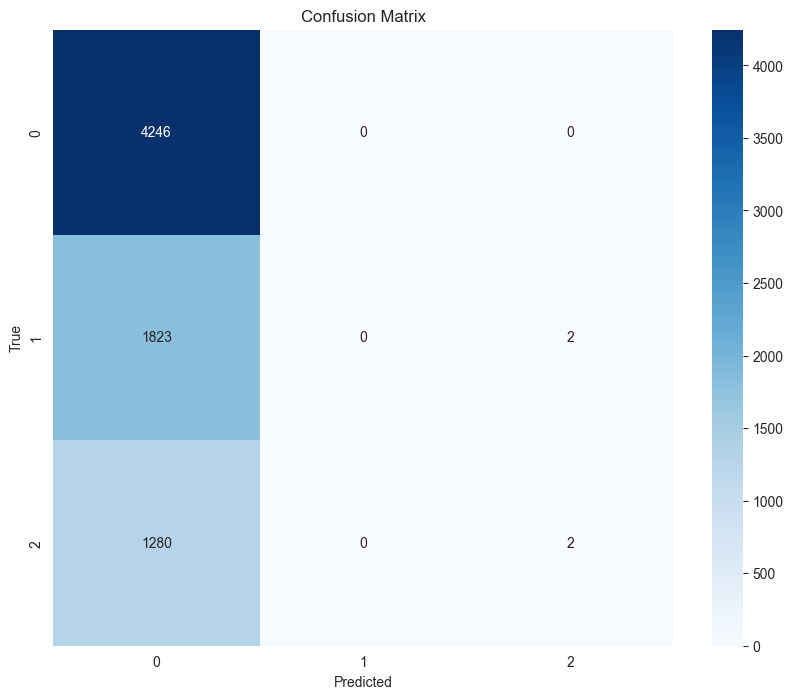


Generating ROC Curves...


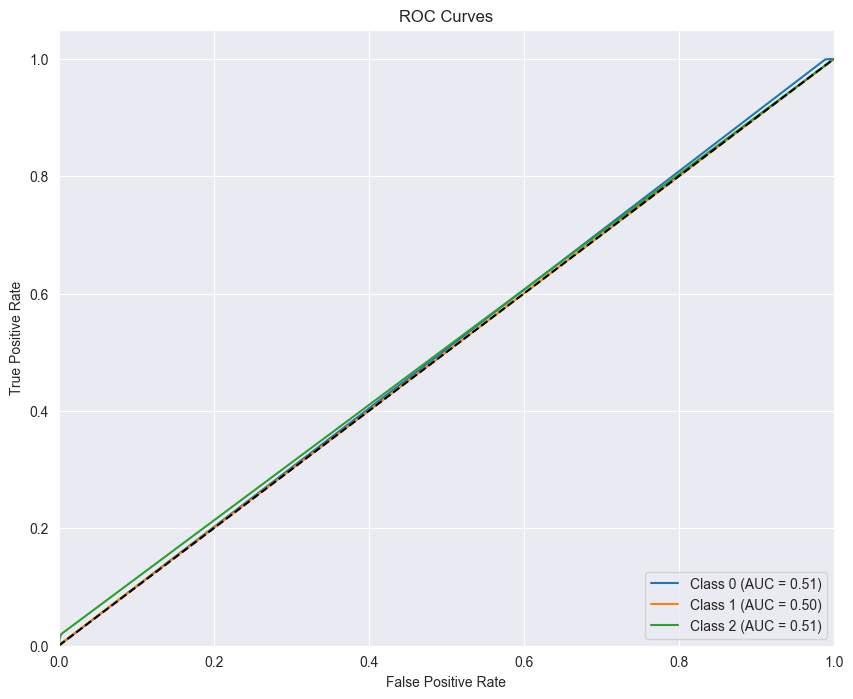


Generating Prediction Distribution...


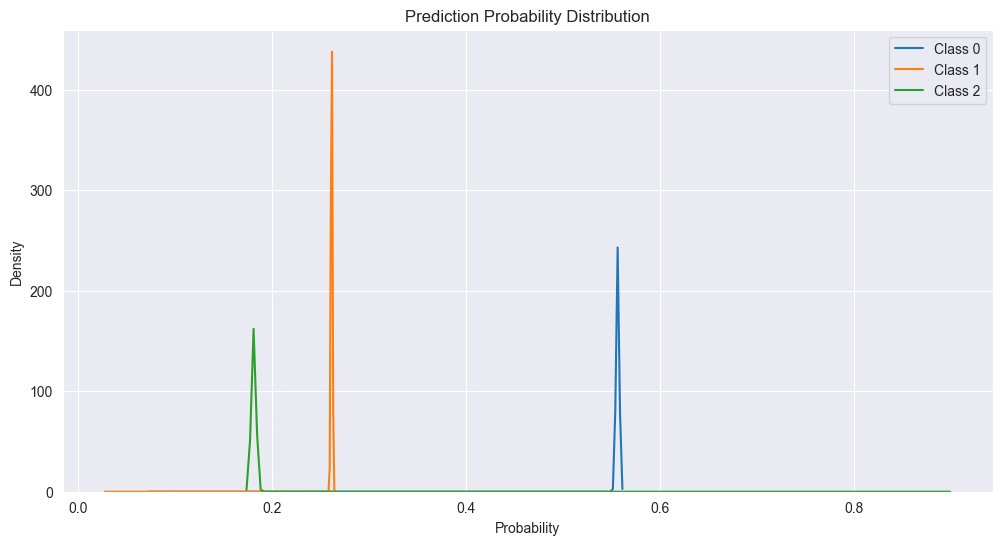


Test Accuracy: 0.5777


In [20]:
get_model_stats(model1)

### Model 2
##### Bidirectional LSTM

In [21]:
# LSTM Model 2: Bidirectional LSTM
model2 = tf.keras.Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(LSTM(128)),
    Dense(3, activation='softmax')
])
model2.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
model2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model2.evaluate(X_test, y_test)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 141s 152ms/step - accuracy: 0.6165 - loss: 0.8781 - val_accuracy: 0.6452 - val_loss: 0.7937
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 155s 169ms/step - accuracy: 0.6806 - loss: 0.7295 - val_accuracy: 0.6528 - val_loss: 0.7881
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 152s 165ms/step - accuracy: 0.7220 - loss: 0.6493 - val_accuracy: 0.6431 - val_loss: 0.8135
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 152s 165ms/step - accuracy: 0.7663 - loss: 0.5643 - val_accuracy: 0.6293 - val_loss: 0.8970
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 151s 164ms/step - accuracy: 0.8036 - loss: 0.4854 - val_accuracy: 0.6140 - val_loss: 0.9817
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6109 - loss: 0.9813


[0.9816679954528809, 0.6140350699424744]

230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      4246
           1       0.59      0.58      0.58      1825
           2       0.39      0.27      0.32      1282

    accuracy                           0.61      7353
   macro avg       0.55      0.53      0.53      7353
weighted avg       0.60      0.61      0.60      7353


Generating Confusion Matrix...


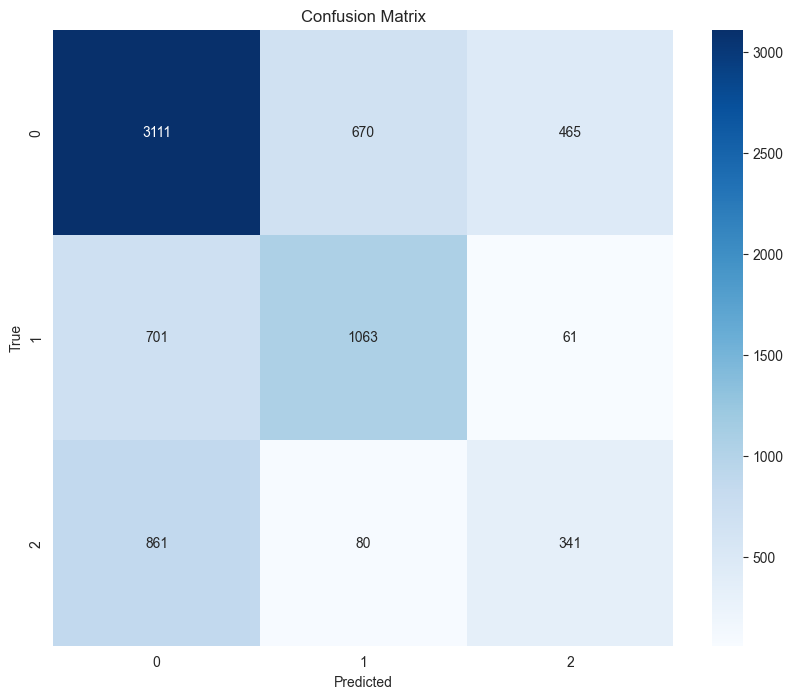


Generating ROC Curves...


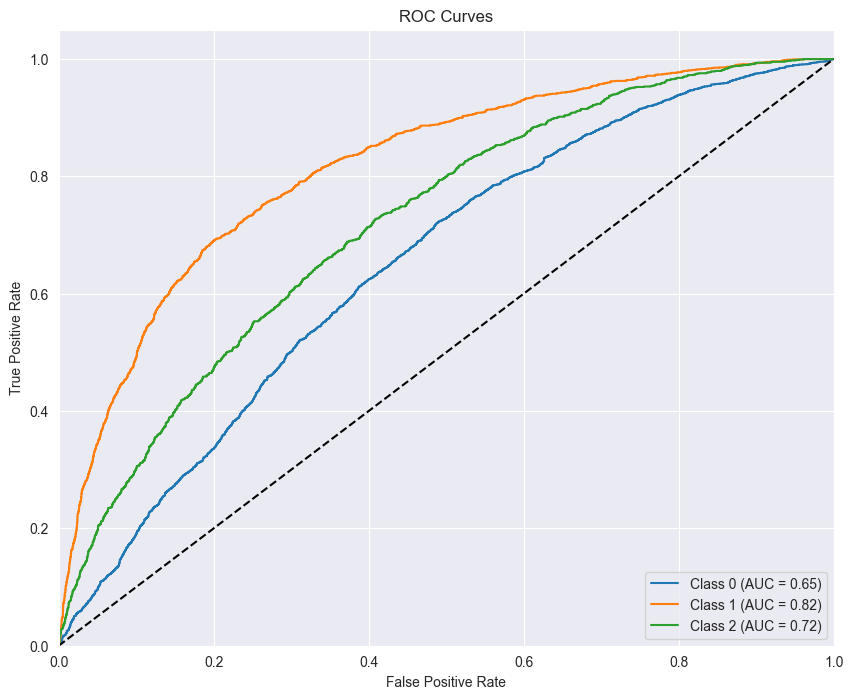


Generating Prediction Distribution...


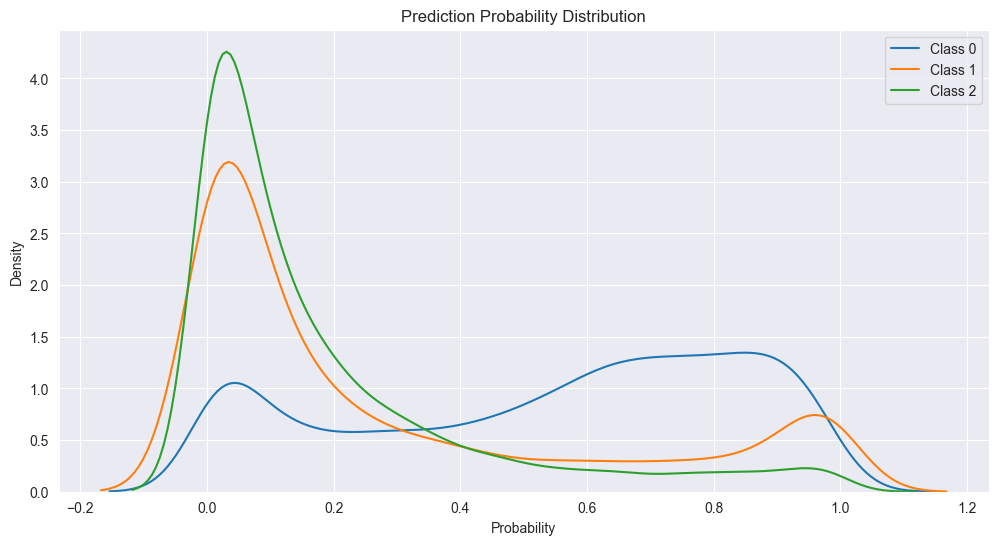


Test Accuracy: 0.5777


In [23]:
get_model_stats(model2)

### Model 3
##### LSTM with Dropout

In [24]:
# LSTM Model 3: LSTM with Dropout
model3 = tf.keras.Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax')
])
model3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
model3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model3.evaluate(X_test, y_test)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 117s 126ms/step - accuracy: 0.5694 - loss: 0.9779 - val_accuracy: 0.5775 - val_loss: 0.9712
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 116s 126ms/step - accuracy: 0.5639 - loss: 0.9876 - val_accuracy: 0.5775 - val_loss: 0.9690
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 125s 135ms/step - accuracy: 0.5732 - loss: 0.9720 - val_accuracy: 0.5775 - val_loss: 0.9705
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 117s 128ms/step - accuracy: 0.5660 - loss: 0.9780 - val_accuracy: 0.5775 - val_loss: 0.9677
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.5696 - loss: 0.9751 - val_accuracy: 0.5775 - val_loss: 0.9703
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5773 - loss: 0.9717


[0.9702699780464172, 0.5774514079093933]

230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      4246
           1       1.00      0.00      0.00      1825
           2       1.00      0.00      0.00      1282

    accuracy                           0.58      7353
   macro avg       0.86      0.33      0.24      7353
weighted avg       0.76      0.58      0.42      7353


Generating Confusion Matrix...


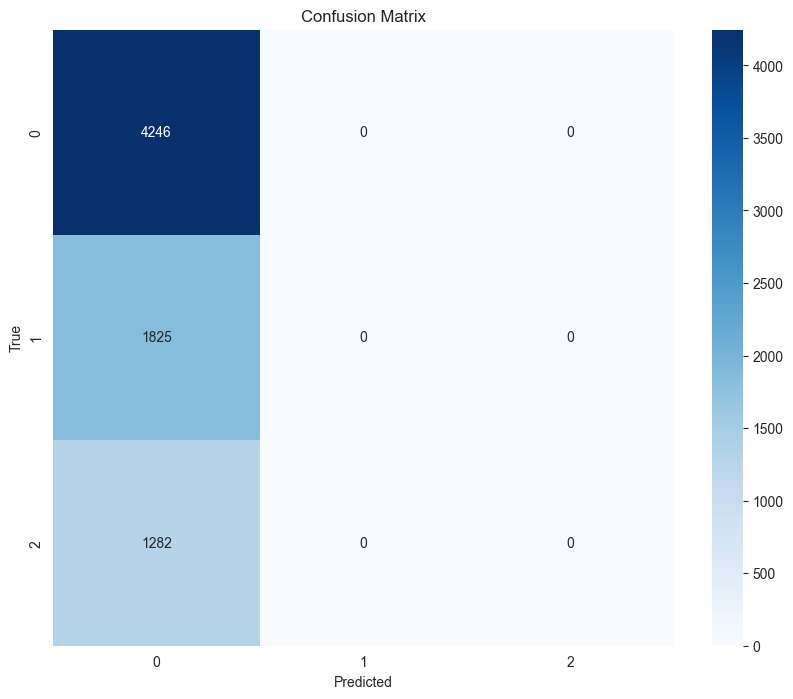


Generating ROC Curves...


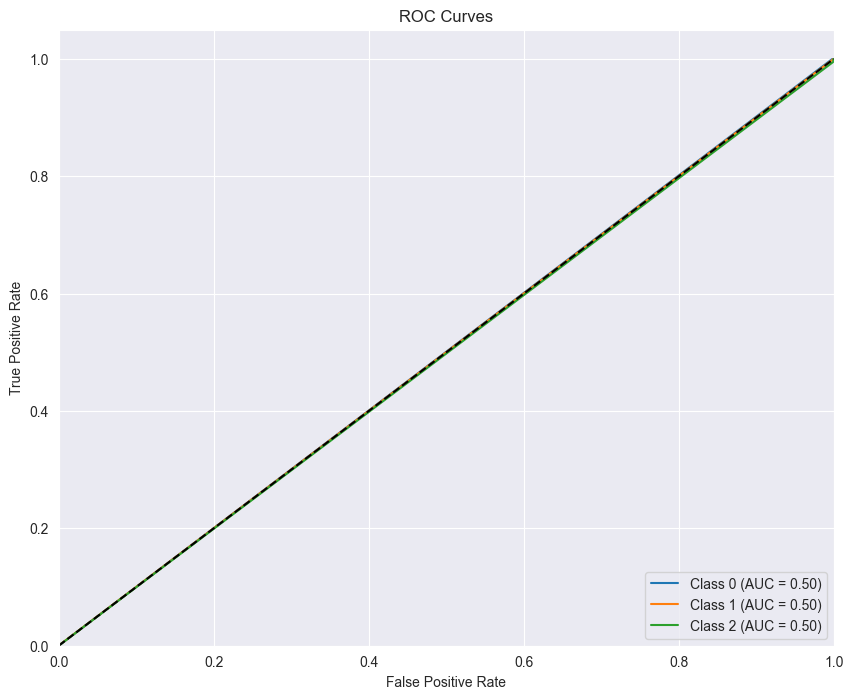


Generating Prediction Distribution...


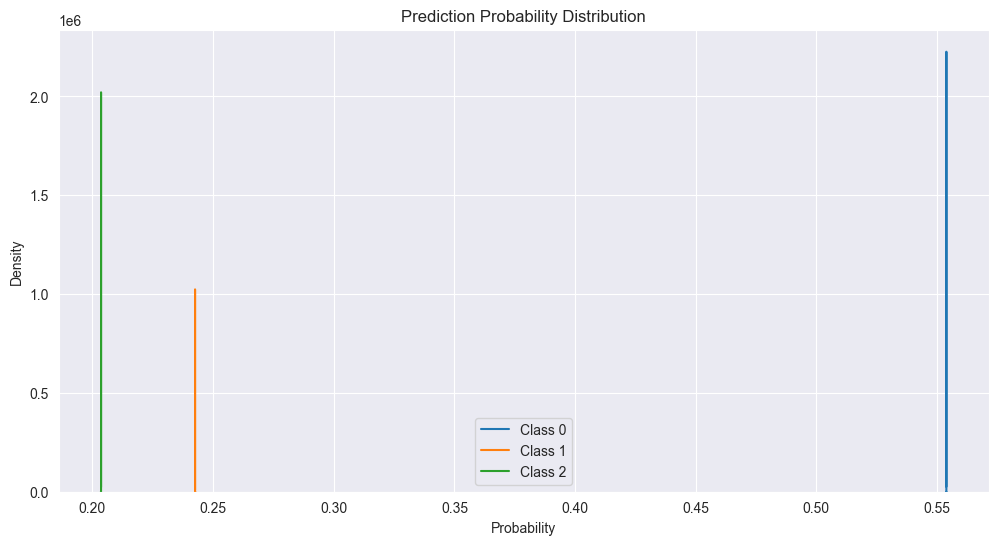


Test Accuracy: 0.5777


In [26]:
get_model_stats(model3)